In [118]:
import pandas as pd
import os
from keplergl import KeplerGl
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

In [119]:
# Load only the essential columns for Kepler OD map
essential_cols = ['start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']

df = pd.read_pickle(r'../02 Data/df_merged_3.0.pkl')[essential_cols]

In [120]:
df.head()

,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng
0,Flatbush Ave & Ocean Ave,3 St & Prospect Park West,40.663658,-73.963013,40.668133,-73.973640
1,Forsyth St\t& Grand St,E 11 St & 1 Ave,40.717796,-73.993164,40.729538,-73.984268
2,Perry St & Bleecker St,Grand St & Greene St,40.735355,-74.004829,40.721699,-74.002380
3,FDR Drive & E 35 St,Grand Army Plaza & Central Park S,40.744221,-73.971214,40.764397,-73.973717
4,E 40 St & 5 Ave,Ave A & E 14 St,40.752052,-73.982117,40.730312,-73.980469


# Missing values treatment

In [121]:
df.isnull().sum()

start_station_name        0
end_station_name          0
start_lat                 0
start_lng                 0
end_lat               37221
end_lng               37221
dtype: int64

In [122]:
common_stations = set(df['start_station_name'].unique()) & set(df['end_station_name'].unique())
len(common_stations)

1756

In [123]:
# create a reference table of stations with coordinates from the starting points
stations = (
    df[["start_station_name", "start_lat", "start_lng"]]
    .dropna(subset=["start_lat", "start_lng"])  # исключаем пустые
    .drop_duplicates()
    .rename(columns={
        "start_station_name": "station_name",
        "start_lat": "lat",
        "start_lng": "lng"
    })
)

In [124]:
# Create a copy of only those rows where the end stations have no coordinates
missing_ends = (
    df[df["end_lat"].isna()]
    [["end_station_name"]]
    .drop_duplicates()
)

In [125]:
# Create a copy of only those rows where the end stations have no coordinates
missing_ends = missing_ends.merge(
    stations,
    how="left",
    left_on="end_station_name",
    right_on="station_name"
)

In [126]:
# Create dictionaries for quick coordinate lookup by station name
lat_map = dict(zip(missing_ends["end_station_name"], missing_ends["lat"]))
lng_map = dict(zip(missing_ends["end_station_name"], missing_ends["lng"]))

# Fill in missing coordinates directly where they are absent
df.loc[df["end_lat"].isna(), "end_lat"] = df.loc[df["end_lat"].isna(), "end_station_name"].map(lat_map)
df.loc[df["end_lng"].isna(), "end_lng"] = df.loc[df["end_lng"].isna(), "end_station_name"].map(lng_map)

In [127]:
df.isnull().sum()

start_station_name    0
end_station_name      0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
dtype: int64

In [128]:
df.columns

Index(['start_station_name', 'end_station_name', 'start_lat', 'start_lng',
       'end_lat', 'end_lng'],
      dtype='object')

# Data preprocessing

In [129]:
df['trips'] = 1

In [130]:
df_group = df.groupby(['start_station_name', 'end_station_name'])['trips'].count().reset_index()

In [131]:
df_group['trips'].sum()

29806700

In [132]:
df['trips'].sum()

29806700

In [133]:
df_group.shape

(1013320, 3)

In [134]:
df_group.head()

,start_station_name,end_station_name,trips
0,1 Ave & E 110 St,1 Ave & E 110 St,791
1,1 Ave & E 110 St,1 Ave & E 18 St,2
2,1 Ave & E 110 St,1 Ave & E 30 St,4
3,1 Ave & E 110 St,1 Ave & E 39 St,1
4,1 Ave & E 110 St,1 Ave & E 44 St,12


In [135]:
df_group['trips'].describe()

count    1.013320e+06
mean     2.941489e+01
std      9.916538e+01
min      1.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.700000e+01
max      1.204100e+04
Name: trips, dtype: float64

In [136]:
df_group['trips'].sort_index().value_counts()

1       267668
2       127962
3        77927
4        54713
5        40719
         ...  
1408         1
2988         1
1649         1
2468         1
1252         1
Name: trips, Length: 1847, dtype: int64

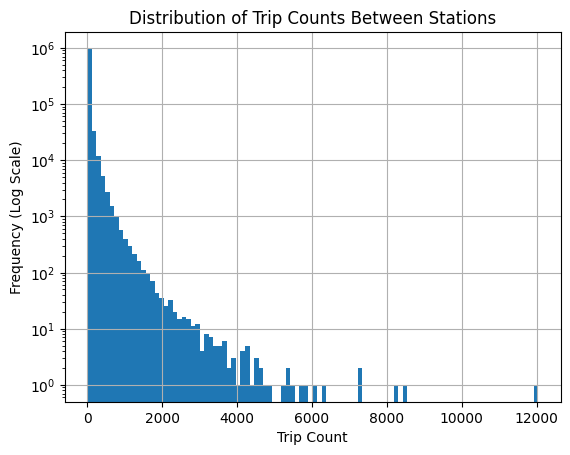

In [137]:
# Plot histogram of trip counts between stations to see distribution
df_group['trips'].hist(bins=100)
plt.yscale('log')  # Log scale to handle skewness
plt.xlabel("Trip Count")
plt.ylabel("Frequency (Log Scale)")
plt.title("Distribution of Trip Counts Between Stations")
plt.show()

<Axes: >

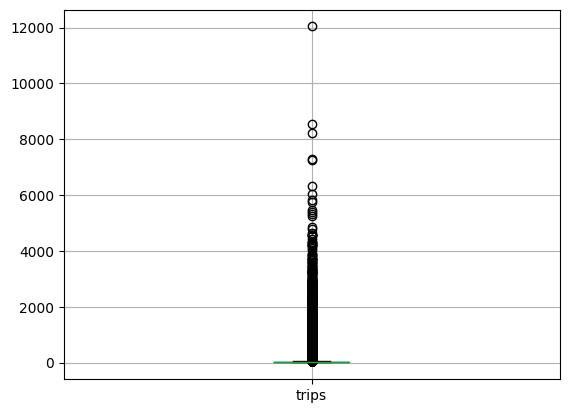

In [138]:
df_group.boxplot(column = 'trips') 

In [139]:
df_group.to_csv('df_groupby_final.csv')

In [140]:
import gc # this is garbage collector - speeds up performance
gc.collect()

19806

# Pareto analysis: find top 20% routes covering 80% of trips 

In [141]:
df_trips = (
    df_group.groupby(
        ['start_station_name', 'end_station_name'],
        as_index=False
    )['trips'].first()      
)

In [142]:
df_trips.shape

(1013320, 3)

In [143]:
df_trips['trips'].sum()

29806700

In [144]:
df_trips.head()

,start_station_name,end_station_name,trips
0,1 Ave & E 110 St,1 Ave & E 110 St,791
1,1 Ave & E 110 St,1 Ave & E 18 St,2
2,1 Ave & E 110 St,1 Ave & E 30 St,4
3,1 Ave & E 110 St,1 Ave & E 39 St,1
4,1 Ave & E 110 St,1 Ave & E 44 St,12


In [145]:
# Sort routes by number of trips (descending)
routes_sorted = df_trips.sort_values(by='trips', ascending=False)

# Calculate cumulative share (running %)
routes_sorted['cum_share'] = routes_sorted['trips'].cumsum() / routes_sorted['trips'].sum()

# Select the top routes that together account for 80% of all trips
top_80_routes = routes_sorted[routes_sorted['cum_share'] <= 0.8]

# Count how many routes and what % of all routes they represent
top_count = len(top_80_routes)
total_routes = len(routes_sorted)
share_of_routes = top_count / total_routes

print(f"TOP ROUTES: {top_count} routes ({share_of_routes:.1%} of all) cover 80% of total trips.")
top_80_routes.head()


TOP ROUTES: 146682 routes (14.5% of all) cover 80% of total trips.


,start_station_name,end_station_name,trips,cum_share
294965,Central Park S & 6 Ave,Central Park S & 6 Ave,12041,0.000404
147924,7 Ave & Central Park South,7 Ave & Central Park South,8541,0.000691
782323,Roosevelt Island Tramway,Roosevelt Island Tramway,8211,0.000966
800555,Soissons Landing,Soissons Landing,7275,0.001210
548185,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7259,0.001454


In [146]:
# Adding coordinates to top_80_routes df

In [147]:
# 1. Extract unique start station coordinates
start_coords = df_merged[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates('start_station_name')

In [148]:
# 2. Extract unique end station coordinates
end_coords = df_merged[['end_station_name', 'end_lat', 'end_lng']].drop_duplicates('end_station_name')

In [149]:
# 3. Add coordinates into df_trips (or routes_sorted / top_80_routes)
df_pareto = top_80_routes.merge(start_coords, on='start_station_name', how='left')

In [150]:
df_pareto = df_pareto.merge(end_coords, on='end_station_name', how='left')

In [151]:
df_pareto.head()

,start_station_name,end_station_name,trips,cum_share,start_lat,start_lng,end_lat,end_lng
0,Central Park S & 6 Ave,Central Park S & 6 Ave,12041,0.000404,40.765911,-73.976341,40.765911,-73.976341
1,7 Ave & Central Park South,7 Ave & Central Park South,8541,0.000691,40.766739,-73.979073,40.766739,-73.979073
2,Roosevelt Island Tramway,Roosevelt Island Tramway,8211,0.000966,40.757282,-73.953598,40.757282,-73.953598
3,Soissons Landing,Soissons Landing,7275,0.001210,40.692318,-74.014862,40.692318,-74.014862
4,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7259,0.001454,40.764397,-73.973717,40.764397,-73.973717


In [152]:
df_pareto.shape

(146682, 8)

In [153]:
df_pareto.to_pickle('df_pareto.pkl')

# Mapping

In [154]:
df_pareto['trips'].describe()

count    146682.000000
mean        162.564950
std         216.224872
min          42.000000
25%          61.000000
50%          97.000000
75%         179.000000
max       12041.000000
Name: trips, dtype: float64

This summary describes only the routes that together make up 80% of all CitiBike trips.

count = 146,682	There are 146,682 unique routes in the “Pareto group” (≈14.5% of all routes).
mean = 162.6	On average, each of these routes has ~163 trips per year.
std = 216.2	The number of trips varies significantly across routes.
min = 42	The least popular route in the Pareto group has 42 trips.
25% = 61	25% of key routes have 61 trips or fewer.
50% (median) = 97	Half of the key routes have fewer than 97 trips.
75% = 179	75% of the key routes have fewer than 179 trips.
max = 12,041	The most popular route has 12,041 trips.

In [155]:
import gc # this is garbage collector - speeds up performance
gc.collect()

0

Purpose of the visualization

The goal of this Kepler.gl map is to visualize the flow of Citi Bike trips across New York City and understand where demand is concentrated.
To do that, I used:

Arc layer — to draw connections (routes) between start and end stations.

Heat/color scale — to reflect the start point and end point.

Steps performed in Python:

Aggregated the dataset by route
→ start_station_name + end_station_name → trips

Applied the Pareto principle (80/20 rule)
→ selected only the top routes that account for 80% of all bike trips.

Merged coordinates into the aggregated routes so Kepler can draw arcs.

Loaded into Kepler.gl and applied:

Arc Layer (Start → End station)

Color encoding

Result: the map shows only the most relevant routes instead of millions of individual rides.

In [156]:
# Create KeplerGl instance

map_1 = KeplerGl(height = 700, data={"data_1": df_pareto})
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':                        start_station_name                   end_station_name  \
0    …

According to the Pareto principle, only 14.5% of all CitiBike routes account for 80% of total trips.
These routes average 163 trips each, with the busiest single origin–destination pair generating 12,041 trips.

Optimizing bike repositioning on just the top 14.5% of routes would address 80% of the demand.
This dramatically reduces the search space for operational planning.

The Kepler map shows Citi Bike routes in New York City using arc connections between start and end stations. The color of each arc represents the number of trips on that route. Brighter colors indicate higher usage, while darker colors indicate fewer trips. Only the most frequent routes were visualized — specifically the routes that together account for 80% of all Citi Bike trips. This was done using a Pareto analysis, which revealed that only about 14.5% of all unique routes generate 80% of total rides.
The map shows a very dense concentration of routes in Midtown and Lower Manhattan. These areas have the highest demand and represent a mix of commuter activity and tourism. There is a high volume of routes around Central Park and along the Hudson River Greenway. These routes are typically recreational and popular with casual riders.
As the map moves outward from Manhattan, the number of routes decreases significantly. In the outer boroughs, such as Queens, the Bronx, and the deeper parts of Brooklyn, there are far fewer arcs. This is due to lower station density and less bike infrastructure compared to Manhattan. Jersey City and Roosevelt Island show isolated clusters of trips, but these areas are not strongly connected to the main Manhattan network.
Overall, the map clearly indicates that Citi Bike demand is concentrated in the core of Manhattan, where trips are short, dense, and repetitive. This suggests that operational planning — such as bike rebalancing and fleet distribution — should prioritize central Manhattan and the key corridors highlighted on the map.

In [165]:
config = map_1.config

In [166]:
config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data_1'],
     'id': '80e8yc23',
     'name': ['trips'],
     'type': 'range',
     'value': [1717, 12041],
     'enlarged': False,
     'plotType': 'histogram',
     'animationWindow': 'free',
     'yAxis': None,
     'speed': 1}],
   'layers': [{'id': 'vdyiq5h',
     'type': 'point',
     'config': {'dataId': 'data_1',
      'label': 'start',
      'color': [164, 13, 119],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'start_lat', 'lng': 'start_lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       

In [167]:
import json
with open("config.json", "w") as outfile:
    json.dump(config, outfile)

In [168]:
map_1.save_to_html(file_name = 'nyc_bike_map.html', read_only = False, config = config)

Map saved to nyc_bike_map.html!


# Suggested Plan to Improve Future Analysis

To extend and enhance the City Bike research, future analyses could include the following directions:


Transport Service Disruptions:
Incorporate data on temporary service interruptions caused by construction, maintenance, or street closures—particularly during nighttime hours—to better understand their effect on trip volume and route selection.

Event and Seasonal Planning:
Analyze areas near main routes and major venues by integrating city event calendars (e.g., concerts, festivals, sports events). This would help anticipate demand spikes and optimize bike availability in advance of large gatherings.